<a href="https://colab.research.google.com/github/gitgubbenito/capstone/blob/main/VAERS-v2.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Capstone Project - Vaccine Adverse Event Reporting System

In [1]:
%reset -f

Data files can be found at the following location:
https://vaers.hhs.gov/data/datasets.html

Datasets were to big to be uploaded to github

I focus on 2021 datasets

In [8]:
from datetime import date

import random
import statistics
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import shapiro
from statsmodels.stats import power
from category_encoders import TargetEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, classification_report, cohen_kappa_score, accuracy_score, f1_score, roc_curve, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# to display the float values upto 6 decimal places
pd.options.display.float_format = '{:.6f}'.format

from sklearn.utils import resample

from wordcloud import WordCloud
from wordcloud import STOPWORDS

import nltk
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from nltk.stem.porter import PorterStemmer

In [7]:
#!pip install chardet
#!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 867.9 kB/s eta 0:00:00


In [ ]:
import chardet
with open('/content/drive/MyDrive/capstone/2021VAERSSYMPTOMS.csv', 'rb') as f:
    data = f.read()
    encoding_result = chardet.detect(data)
    encoding = encoding_result['encoding']
    print("Detected Encoding:", encoding)

Detected Encoding: ascii



#Things to do
- Load all 2021 files - done
- Explore Datasets - done
- Merge Datasets - done
- Data Clean-up - done
- Determine the most common sysmtoms by vaccine manu - Done
- How many people were disable o die due to the vaccine - Done
- Number of VAERS by state - Done
- Plot top 20 symtoms - Done
# Questions to be answer
1.  Do people who experience side effects from the vaccine tend to experience them sooner or later after vaccination?
2.  Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?
3.  Is there a noticeable difference in age between those who have no serious side effects and those who do?
4. What are the most common VAERS presented on pacients with COVID-19 vaccine

#ML Model to explore
Clasification models
* K-nearse neibort
* Decision trees
* Logistic regresation
* Support Factor Machine






In [9]:
#Load all 2021 files
df_symptoms_2021 =pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSSYMPTOMS.csv')
df_vaers_data_2021 = pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSDATA.csv',encoding="Windows-1252")
df_vaers_vax_2021 = pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSVAX.csv',encoding="Windows-1252")


In [8]:
print(df_symptoms_2021.head())

   VAERS_ID          SYMPTOM1  SYMPTOMVERSION1              SYMPTOM2  \
0    910642          Dyspnoea             25.0  Heart rate increased   
1    916600         Dysphagia             23.1          Epiglottitis   
2    916601           Anxiety             23.1              Dyspnoea   
3    916602  Chest discomfort             23.1             Dysphagia   
4    916603         Dizziness             23.1               Fatigue   

   SYMPTOMVERSION2                  SYMPTOM3  SYMPTOMVERSION3  \
0             25.0  SARS-CoV-2 test negative             25.0   
1             23.1                       NaN              NaN   
2             23.1                       NaN              NaN   
3             23.1         Pain in extremity             23.1   
4             23.1        Mobility decreased             23.1   

            SYMPTOM4  SYMPTOMVERSION4 SYMPTOM5  SYMPTOMVERSION5  
0                NaN              NaN      NaN              NaN  
1                NaN              NaN      N

In [ ]:
# Concatenate all columns SYMPTOM1, SYMPTOM4, SYMPTOM2,SYMPTOM3, SYMPTOM4, SYMPTOM5

df_symptoms_2021['ALL_SYMPTOMS'] = df_symptoms_2021[['SYMPTOM1', 'SYMPTOM4', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [10]:
# Explore Datasets
print("Shape of df_symptoms_2021:", df_symptoms_2021.shape)
print("Shape of df_vaers_data_2021:", df_vaers_data_2021.shape)
print("Shape of df_vaers_vax_2021:", df_vaers_vax_2021.shape)


Shape of df_symptoms_2021: (1003896, 12)
Shape of df_vaers_data_2021: (753006, 35)
Shape of df_vaers_vax_2021: (797081, 8)


In [11]:
df_symptoms_2021.head(3)

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,ALL_SYMPTOMS
0,910642,Dyspnoea,25.0,Heart rate increased,25.0,SARS-CoV-2 test negative,25.0,NaN,NaN,NaN,NaN,Dyspnoea Heart rate increased SARS-CoV-2 test ...
1,916600,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN,Dysphagia Epiglottitis
2,916601,Anxiety,23.1,Dyspnoea,23.1,NaN,NaN,NaN,NaN,NaN,NaN,Anxiety Dyspnoea


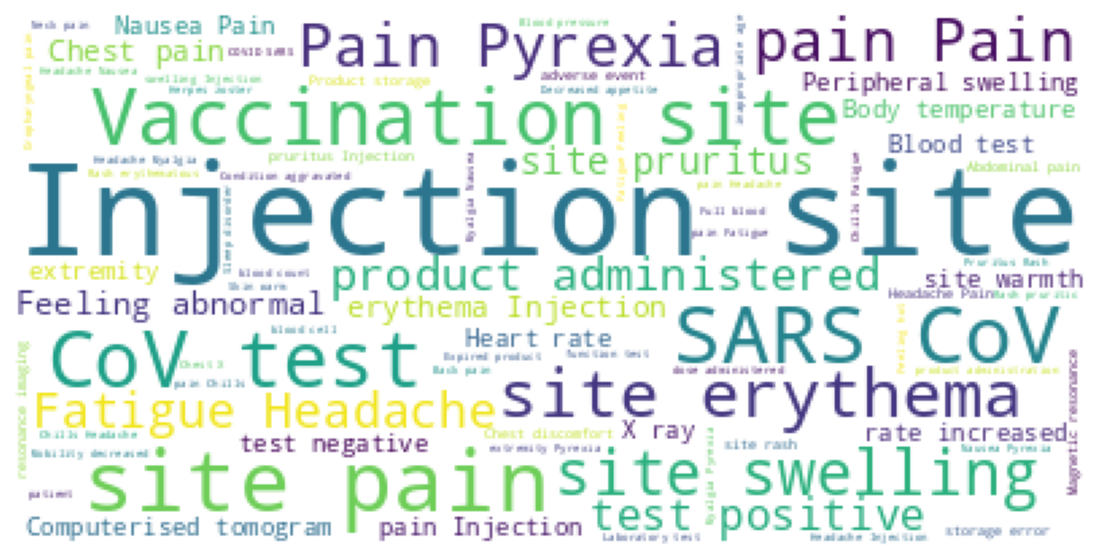

In [ ]:
import matplotlib.pyplot as plt
# Get the text from the ALL_SYMPTOMS column
text = ' '.join(df_symptoms_2021['ALL_SYMPTOMS'].tolist())

# Create a word cloud
wordcloud = WordCloud(
    background_color='white',
    max_font_size=50).generate(text)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()


In [13]:
# prompt: drop FORM_VERS , SYMPTOMVERSION3,SYMPTOMVERSION4,SYMPTOMVERSION1, SYMPTOMVERSION2 , ignore errors

df_symptoms_2021.drop(columns=['FORM_VERS', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION1', 'SYMPTOMVERSION2','SYMPTOMVERSION5' ], errors='ignore', inplace=True)



In [14]:
# prompt: df_symptoms_2021 head

print(df_symptoms_2021.head())


   VAERS_ID          SYMPTOM1              SYMPTOM2                  SYMPTOM3  \
0    910642          Dyspnoea  Heart rate increased  SARS-CoV-2 test negative   
1    916600         Dysphagia          Epiglottitis                       NaN   
2    916601           Anxiety              Dyspnoea                       NaN   
3    916602  Chest discomfort             Dysphagia         Pain in extremity   
4    916603         Dizziness               Fatigue        Mobility decreased   

            SYMPTOM4 SYMPTOM5  \
0                NaN      NaN   
1                NaN      NaN   
2                NaN      NaN   
3  Visual impairment      NaN   
4                NaN      NaN   

                                        ALL_SYMPTOMS  
0  Dyspnoea Heart rate increased SARS-CoV-2 test ...  
1                             Dysphagia Epiglottitis  
2                                   Anxiety Dyspnoea  
3  Chest discomfort Visual impairment Dysphagia P...  
4               Dizziness Fatigue Mobil

In [15]:
# prompt: count unique  SYMPTOMS

num_unique_symptoms = df_symptoms_2021['SYMPTOM1'].nunique()
print(f"Number of unique symptoms: {num_unique_symptoms}")




Number of unique symptoms: 7654


In [16]:
# Explore Datasets
df_symptoms_2021.isnull().sum()

VAERS_ID             0
SYMPTOM1             0
SYMPTOM2        225538
SYMPTOM3        408255
SYMPTOM4        551438
SYMPTOM5        665894
ALL_SYMPTOMS         0
dtype: int64

In [19]:
# prompt: drop VAX_LOT ,  VAX_DOSE_SERIES, VAX_ROUTE , VAX_SITE,

df_vaers_vax_2021.drop(columns=['VAX_LOT', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5', 'RECVDATE', 'RPT_DATE', 'LAB_DATA', 'V_FUNDBY', 'SPLTTYPE', 'FORM_VERS', 'CAGE_MO', 'DATEDIED', 'HOSPDAYS', 'TODAYS_DATE', 'OTHER_MEDS'], errors='ignore',inplace=True)




In [20]:
df_vaers_vax_2021.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_DOSE_SERIES
0,910642,COVID19,PFIZER\BIONTECH,1
1,916600,COVID19,MODERNA,1
2,916601,COVID19,MODERNA,1
3,916602,COVID19,PFIZER\BIONTECH,1
4,916603,COVID19,MODERNA,UNK


In [21]:
# prompt: drop V_FUNDBY, V_ADMINBY, OTHER_MEDS

df_vaers_data_2021.drop(columns=['V_FUNDBY', 'V_ADMINBY', 'OTHER_MEDS'], inplace=True, errors='ignore')


In [22]:
# prompt: drop PRIOR_VAX, TODAYS_DATE, PRIOR_VAX ,CUR_ILL , LAB_DATA

df_vaers_data_2021.drop(columns=['PRIOR_VAX', 'TODAYS_DATE', 'PRIOR_VAX' ,'CUR_ILL' , 'LAB_DATA'], inplace=True, errors='ignore')


In [23]:
# Explore Datasets
df_vaers_data_2021.isnull().sum()

VAERS_ID             0
RECVDATE             0
STATE           115887
AGE_YRS          81007
CAGE_YR         148654
CAGE_MO         748705
SEX                  0
RPT_DATE        752078
SYMPTOM_TEXT       577
DIED            742456
DATEDIED        743627
L_THREAT        741891
ER_VISIT        752879
HOSPITAL        705537
HOSPDAYS        721807
X_STAY          752628
DISABLE         741033
RECOVD           73431
VAX_DATE         55745
ONSET_DATE       65815
NUMDAYS          94529
HISTORY         378107
SPLTTYPE        533091
FORM_VERS            0
BIRTH_DEFECT    752547
OFC_VISIT       608478
ER_ED_VISIT     662703
ALLERGIES       454461
dtype: int64

In [25]:
df_vaers_data_2021.head(12)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,VAX_DATE,ONSET_DATE,NUMDAYS,HISTORY,SPLTTYPE,FORM_VERS,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,12/28/2020,12/30/2020,2.0,NaN,NaN,2,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,12/31/2020,12/31/2020,0.0,Patient residing at nursing facility. See pati...,NaN,2,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,12/31/2020,12/31/2020,0.0,NaN,NaN,2,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,12/23/2020,12/23/2020,0.0,"diverticulitis, mitral valve prolapse, osteoar...",NaN,2,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,12/22/2020,12/29/2020,7.0,NaN,NaN,2,NaN,NaN,NaN,Na
5,916605,01/01/2021,TX,40.0,40.0,NaN,M,NaN,"Adverse Events: Inflammation in the eye, confu...",NaN,...,09/25/2020,09/26/2020,1.0,NaN,NaN,2,NaN,Y,NaN,NaN
6,916606,01/01/2021,NV,44.0,44.0,NaN,F,NaN,patient called back the next day and stated he...,NaN,...,12/29/2020,12/29/2020,0.0,NaN,NaN,2,NaN,NaN,NaN,iodine (shellfish) has epipen
7,916607,01/01/2021,KS,50.0,50.0,NaN,M,NaN,SEVERE chills approximately 13-14 hours after ...,NaN,...,12/28/2020,12/29/2020,1.0,"High blood pressure, high cholesterol, sleep a...",NaN,2,NaN,NaN,NaN,Penicillin
8,916608,01/01/2021,OH,33.0,33.0,NaN,M,NaN,Nasal congestion and diarrhea,NaN,...,12/29/2020,12/31/2020,2.0,NaN,NaN,2,NaN,NaN,NaN,NaN
9,916609,01/01/2021,TN,71.0,71.0,NaN,F,NaN,On day 9 following the vaccination I noticed a...,NaN,...,12/23/2020,12/31/2020,8.0,"Hashimoto's thyroiditis, Hypertension, depression",NaN,2,NaN,NaN,NaN,"Sulfa antibiotics, azithromycin, adhesive in ..."


In [26]:
# prompt: set all DIED rows that are not equal to Y to N

df_vaers_data_2021['DIED'] = df_vaers_data_2021['DIED'].apply(lambda x: 'N' if x != 'Y' else x)


In [28]:
# prompt: Give me a DIED column count

died_count = df_vaers_data_2021['DIED'].value_counts()
print(died_count)




DIED
N    742456
Y     10550
Name: count, dtype: int64


In [29]:
# Explore Datasets
df_symptoms_2021.isnull().sum()

VAERS_ID             0
SYMPTOM1             0
SYMPTOM2        225538
SYMPTOM3        408255
SYMPTOM4        551438
SYMPTOM5        665894
ALL_SYMPTOMS         0
dtype: int64

In [30]:
# Drop  Columns
df_vaers_data_2021 = df_vaers_data_2021.drop(columns =['CAGE_YR', 'CAGE_MO', 'RPT_DATE', 'ONSET_DATE','NUMDAYS', 'LAB_DATA', 'SYMPTOM_TEXT',
                                                   'V_ADMINBY', 'DATEDIED', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'PRIOR_VAX','VAX_DATE',
                                                   'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'OFC_VISIT', 'HISTORY', 'ER_ED_VISIT', 'ALLERGIES',
                                                   'RECVDATE','STATE','HOSPDAYS','X_STAY','RECOVD'],errors='ignore')

In [31]:
df_vaers_data_2021.columns

Index(['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'DISABLE', 'BIRTH_DEFECT'],
      dtype='object')

**Note:** I will focus in column: SYMPTOM1

In [32]:
df_vaers_data_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753006 entries, 0 to 753005
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   VAERS_ID      753006 non-null  int64  
 1   AGE_YRS       671999 non-null  float64
 2   SEX           753006 non-null  object 
 3   DIED          753006 non-null  object 
 4   L_THREAT      11115 non-null   object 
 5   ER_VISIT      127 non-null     object 
 6   HOSPITAL      47469 non-null   object 
 7   DISABLE       11973 non-null   object 
 8   BIRTH_DEFECT  459 non-null     object 
dtypes: float64(1), int64(1), object(7)
memory usage: 51.7+ MB


In [33]:
df_symptoms_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003896 entries, 0 to 1003895
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   VAERS_ID      1003896 non-null  int64 
 1   SYMPTOM1      1003896 non-null  object
 2   SYMPTOM2      778358 non-null   object
 3   SYMPTOM3      595641 non-null   object
 4   SYMPTOM4      452458 non-null   object
 5   SYMPTOM5      338002 non-null   object
 6   ALL_SYMPTOMS  1003896 non-null  object
dtypes: int64(1), object(6)
memory usage: 53.6+ MB


In [34]:
# prompt: drop SYMPTOMVERSION1. SYMPTOMVERSION2 , SYMPTOMVERSION3, SYMPTOMVERSION4, SYMPTOMVERSION5

df_symptoms_2021.drop(['SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5'], axis=1, inplace=True,errors='ignore')


In [36]:
# prompt: how many vaers are by vacine manu

#df_vaers_vax_2021['VAX_MANU'].value_counts()
df_vaers_vax_2021['VAX_TYPE'].value_counts(normalize= True) * 100


VAX_TYPE
COVID19    93.103587
VARZOS      1.800193
UNK         1.187960
FLU4        0.681361
HPV9        0.228835
             ...    
PER         0.000125
DTOX        0.000125
DTPHEP      0.000125
MNQHIB      0.000125
TDAPIPV     0.000125
Name: proportion, Length: 70, dtype: float64

In [37]:
# prompt: merge all 3 data frame

df_combine_2021 = pd.merge(df_vaers_data_2021, df_vaers_vax_2021, on='VAERS_ID', how='inner')
df_combine_2021 = pd.merge(df_combine_2021, df_symptoms_2021, on='VAERS_ID', how='inner')


In [38]:
len(df_combine_2021[df_combine_2021.duplicated(subset= ['VAERS_ID'])== True])
df_combine_2021 = df_combine_2021.drop_duplicates(subset= ['VAERS_ID'], keep= 'first')
# Checking dimension of data after dropping duplicates:
df_combine_2021.shape

(753003, 18)

In [39]:
df_combine_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753003 entries, 0 to 1070233
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         753003 non-null  int64  
 1   AGE_YRS          671996 non-null  float64
 2   SEX              753003 non-null  object 
 3   DIED             753003 non-null  object 
 4   L_THREAT         11113 non-null   object 
 5   ER_VISIT         127 non-null     object 
 6   HOSPITAL         47468 non-null   object 
 7   DISABLE          11973 non-null   object 
 8   BIRTH_DEFECT     459 non-null     object 
 9   VAX_TYPE         753003 non-null  object 
 10  VAX_MANU         753003 non-null  object 
 11  VAX_DOSE_SERIES  749278 non-null  object 
 12  SYMPTOM1         753003 non-null  object 
 13  SYMPTOM2         590865 non-null  object 
 14  SYMPTOM3         453978 non-null  object 
 15  SYMPTOM4         344175 non-null  object 
 16  SYMPTOM5         253853 non-null  object 


In [40]:
df_combine_2021.columns

Index(['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'DISABLE', 'BIRTH_DEFECT', 'VAX_TYPE', 'VAX_MANU',
       'VAX_DOSE_SERIES', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',
       'SYMPTOM5', 'ALL_SYMPTOMS'],
      dtype='object')

In [41]:
# prompt: how many people died by sex

died_by_sex = df_combine_2021.groupby('SEX')['DIED'].value_counts()

print(died_by_sex)


SEX  DIED
F    N       489349
     Y         4110
M    N       218223
     Y         5993
U    N        34881
     Y          447
Name: count, dtype: int64


In [42]:
df_combine_2021.head()

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,VAX_TYPE,VAX_MANU,VAX_DOSE_SERIES,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,ALL_SYMPTOMS
0,916600,33.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Dysphagia,Epiglottitis,NaN,NaN,NaN,Dysphagia Epiglottitis
1,916601,73.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Anxiety,Dyspnoea,NaN,NaN,NaN,Anxiety Dyspnoea
2,916602,23.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,1,Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN,Chest discomfort Visual impairment Dysphagia P...
3,916603,58.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,UNK,Dizziness,Fatigue,Mobility decreased,NaN,NaN,Dizziness Fatigue Mobility decreased
4,916604,47.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN,Injection site erythema Injection site warmth ...


In [43]:
# prompt: how many rows and columns are there for each df

print("df_symptoms_2021 has", df_symptoms_2021.shape[0], "rows and", df_symptoms_2021.shape[1], "columns")
print("df_vaers_data_2021 has", df_vaers_data_2021.shape[0], "rows and", df_vaers_data_2021.shape[1], "columns")
print("df_vaers_vax_2021 has", df_vaers_vax_2021.shape[0], "rows and", df_vaers_vax_2021.shape[1], "columns")
print("df_combine_2021 has", df_combine_2021.shape[0], "rows and", df_combine_2021.shape[1], "columns")


df_symptoms_2021 has 1003896 rows and 7 columns
df_vaers_data_2021 has 753006 rows and 9 columns
df_vaers_vax_2021 has 797081 rows and 4 columns
df_combine_2021 has 753003 rows and 18 columns


In [44]:
df_combine_2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753003 entries, 0 to 1070233
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         753003 non-null  int64  
 1   AGE_YRS          671996 non-null  float64
 2   SEX              753003 non-null  object 
 3   DIED             753003 non-null  object 
 4   L_THREAT         11113 non-null   object 
 5   ER_VISIT         127 non-null     object 
 6   HOSPITAL         47468 non-null   object 
 7   DISABLE          11973 non-null   object 
 8   BIRTH_DEFECT     459 non-null     object 
 9   VAX_TYPE         753003 non-null  object 
 10  VAX_MANU         753003 non-null  object 
 11  VAX_DOSE_SERIES  749278 non-null  object 
 12  SYMPTOM1         753003 non-null  object 
 13  SYMPTOM2         590865 non-null  object 
 14  SYMPTOM3         453978 non-null  object 
 15  SYMPTOM4         344175 non-null  object 
 16  SYMPTOM5         253853 non-null  object 


In [45]:
# prompt: Determine the top 12 most common sysmtoms by vaccine manu

top_12_symptoms = df_combine_2021.groupby('VAX_MANU')['SYMPTOM1'].value_counts().sort_values(ascending=False).head(12)
print(top_12_symptoms)


VAX_MANU         SYMPTOM1               
MODERNA          Chills                     27873
                 Arthralgia                 19522
PFIZER\BIONTECH  Chills                     18298
                 Arthralgia                 16877
                 Dizziness                  15245
MODERNA          Injection site erythema    14281
PFIZER\BIONTECH  COVID-19                   13841
MODERNA          Fatigue                    11811
                 Dizziness                  11130
                 Asthenia                    9787
PFIZER\BIONTECH  Fatigue                     9495
MODERNA          Erythema                    9357
Name: count, dtype: int64


In [46]:
# prompt: systoms for people who die value counts

df_combine_2021.groupby('DIED')['SYMPTOM1'].value_counts()


DIED  SYMPTOM1                  
N     Chills                        54649
      Arthralgia                    41162
      Dizziness                     30579
      Fatigue                       24258
      COVID-19                      22445
                                    ...  
Y     Brain stem syndrome               1
      Hepatic encephalopathy            1
      Breast feeding                    1
      Breast cancer metastatic          1
      Wrong product administered        1
Name: count, Length: 5866, dtype: int64

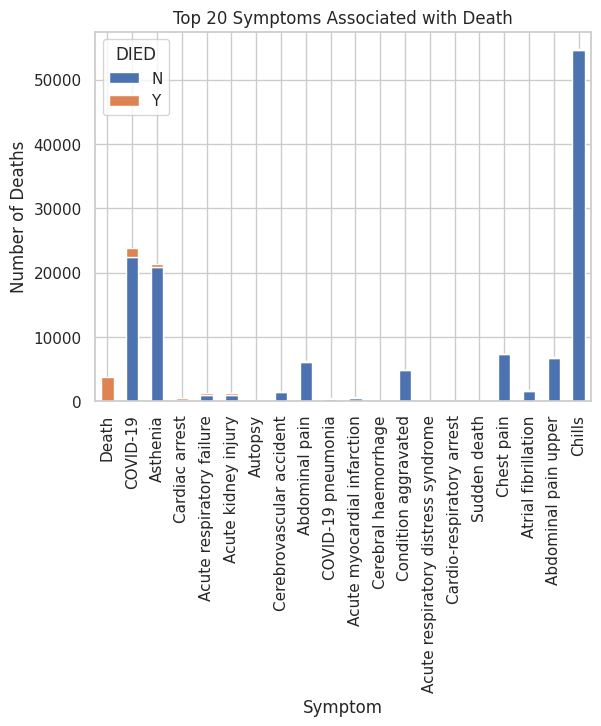

In [47]:
# prompt: plot the most common systom1 who DIED top 20

import matplotlib.pyplot as plt

# Group the data by SYMPTOM1 and DIED
grouped_data = df_combine_2021.groupby(['SYMPTOM1', 'DIED'])['VAERS_ID'].count().unstack()

# Sort the data by the number of deaths
grouped_data = grouped_data.sort_values(by='Y', ascending=False)

# Select the top 20 symptoms
top_20_symptoms = grouped_data.head(20)

# Plot the data as a bar chart
top_20_symptoms.plot(kind='bar', stacked=True)
plt.xlabel('Symptom')
plt.ylabel('Number of Deaths')
plt.title('Top 20 Symptoms Associated with Death')
plt.show()


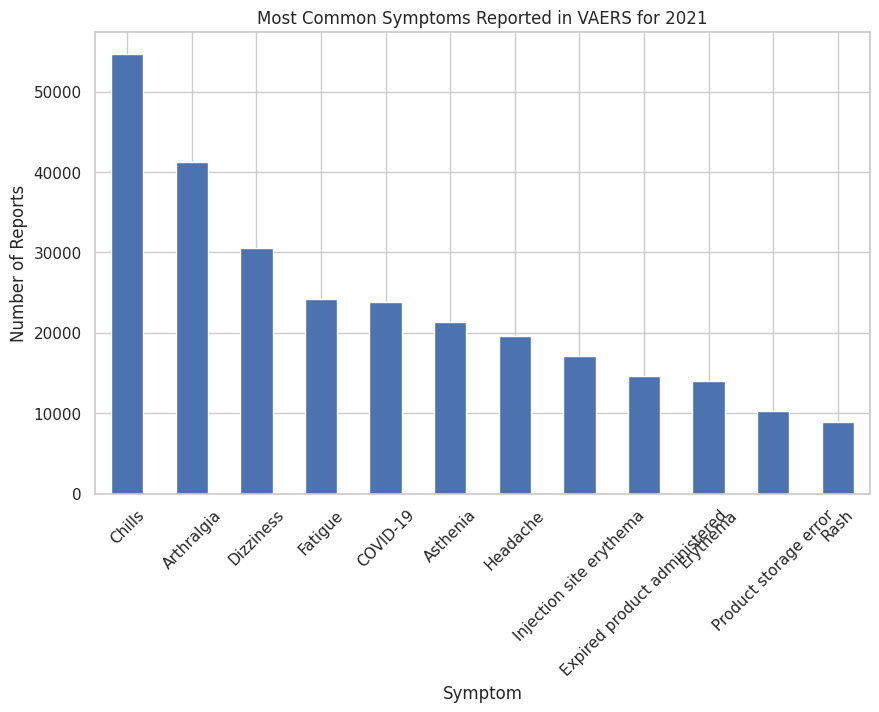

In [48]:
# prompt: plot the most common systom1 and plot it

import matplotlib.pyplot as plt

# Get the top 12 symptoms
top_12_symptoms = df_combine_2021.groupby('SYMPTOM1')['VAERS_ID'].count().sort_values(ascending=False).head(12)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_12_symptoms.plot(kind='bar')

# Add title and labels
plt.title('Most Common Symptoms Reported in VAERS for 2021')
plt.xlabel('Symptom')
plt.ylabel('Number of Reports')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [49]:
# prompt: how many people die by vacine manu

#df_combine_2021.groupby('VAX_MANU')['DIED'].sum()
df_combine_2021.groupby('VAX_MANU')['DIED'].value_counts()


VAX_MANU                           DIED
BERNA BIOTECH, LTD.                N           96
CSL LIMITED                        N            8
DYNAVAX TECHNOLOGIES CORPORATION   N          237
                                   Y            1
EMERGENT BIOSOLUTIONS              N          127
GLAXOSMITHKLINE BIOLOGICALS        N        13843
                                   Y           34
INTERCELL AG                       N            8
JANSSEN                            N        61071
                                   Y         1094
MASS. PUB HLTH BIOL LAB            N           21
MEDIMMUNE VACCINES, INC.           N           63
MERCK & CO. INC.                   N         7545
                                   Y           23
MODERNA                            N       331701
                                   Y         4459
MSP VACCINE COMPANY                N           21
NOVARTIS VACCINES AND DIAGNOSTICS  N         1153
                                   Y            2
PASTEUR ME

In [50]:
df_combine_2021.head(10)

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,VAX_TYPE,VAX_MANU,VAX_DOSE_SERIES,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,ALL_SYMPTOMS
0,916600,33.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Dysphagia,Epiglottitis,NaN,NaN,NaN,Dysphagia Epiglottitis
1,916601,73.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Anxiety,Dyspnoea,NaN,NaN,NaN,Anxiety Dyspnoea
2,916602,23.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,1,Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN,Chest discomfort Visual impairment Dysphagia P...
3,916603,58.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,UNK,Dizziness,Fatigue,Mobility decreased,NaN,NaN,Dizziness Fatigue Mobility decreased
4,916604,47.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN,Injection site erythema Injection site warmth ...
5,916605,40.0,M,N,NaN,NaN,NaN,NaN,NaN,FLUC4,"SEQIRUS, INC.",1,Chills,Confusional state,Eye inflammation,Headache,Laboratory test,Chills Headache Confusional state Eye inflamma...
7,916606,44.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Pharyngeal swelling,NaN,NaN,NaN,NaN,Pharyngeal swelling
8,916607,50.0,M,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,UNK,Abdominal pain,Chills,Sleep disorder,NaN,NaN,Abdominal pain Chills Sleep disorder
9,916608,33.0,M,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Diarrhoea,Nasal congestion,NaN,NaN,NaN,Diarrhoea Nasal congestion
10,916609,71.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Vaccination site erythema,Vaccination site pruritus,Vaccination site swelling,NaN,NaN,Vaccination site erythema Vaccination site pru...


In [51]:
# prompt: what are the values of DIED

df_combine_2021['DIED'].value_counts()


DIED
N    742453
Y     10550
Name: count, dtype: int64

In [52]:
# prompt: top 12 value counts for sysmtoms

df_combine_2021['SYMPTOM1' ].value_counts().head(12)



SYMPTOM1
Chills                          54702
Arthralgia                      41208
Dizziness                       30584
Fatigue                         24268
COVID-19                        23817
Asthenia                        21300
Headache                        19648
Injection site erythema         17188
Expired product administered    14671
Erythema                        13968
Product storage error           10296
Rash                             8947
Name: count, dtype: int64

In [53]:
df_combine_2021.columns

Index(['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'DISABLE', 'BIRTH_DEFECT', 'VAX_TYPE', 'VAX_MANU',
       'VAX_DOSE_SERIES', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',
       'SYMPTOM5', 'ALL_SYMPTOMS'],
      dtype='object')

In [54]:
df_combine_2021.info()


<class 'pandas.core.frame.DataFrame'>
Index: 753003 entries, 0 to 1070233
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         753003 non-null  int64  
 1   AGE_YRS          671996 non-null  float64
 2   SEX              753003 non-null  object 
 3   DIED             753003 non-null  object 
 4   L_THREAT         11113 non-null   object 
 5   ER_VISIT         127 non-null     object 
 6   HOSPITAL         47468 non-null   object 
 7   DISABLE          11973 non-null   object 
 8   BIRTH_DEFECT     459 non-null     object 
 9   VAX_TYPE         753003 non-null  object 
 10  VAX_MANU         753003 non-null  object 
 11  VAX_DOSE_SERIES  749278 non-null  object 
 12  SYMPTOM1         753003 non-null  object 
 13  SYMPTOM2         590865 non-null  object 
 14  SYMPTOM3         453978 non-null  object 
 15  SYMPTOM4         344175 non-null  object 
 16  SYMPTOM5         253853 non-null  object 


In [55]:
# prompt: # prompt: drop SYMPTOM2 ,SYMPTOM3, SYMPTOM4, SYMPTOM5,BIRTH_DEFECT, SYMPTOM, ignore errors

df_combine_2021.drop(columns=['SYMPTOM2','SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5','BIRTH_DEFECT', 'SYMPTOM'], errors='ignore', inplace=True)


In [56]:
# prompt: count  VAX_TYPE and print by value type

df_combine_2021['VAX_TYPE'].value_counts()


VAX_TYPE
COVID19    710665
VARZOS      12888
UNK          6623
FLU4         4356
HPV9         1475
            ...  
DTPHEP          1
PER             1
FLUR3           1
HEPATYP         1
H5N1            1
Name: count, Length: 63, dtype: int64

In [57]:
# prompt: keep all row where VAX_TYPE is COVID19

df_combine_2021 = df_combine_2021[df_combine_2021['VAX_TYPE'] == 'COVID19']


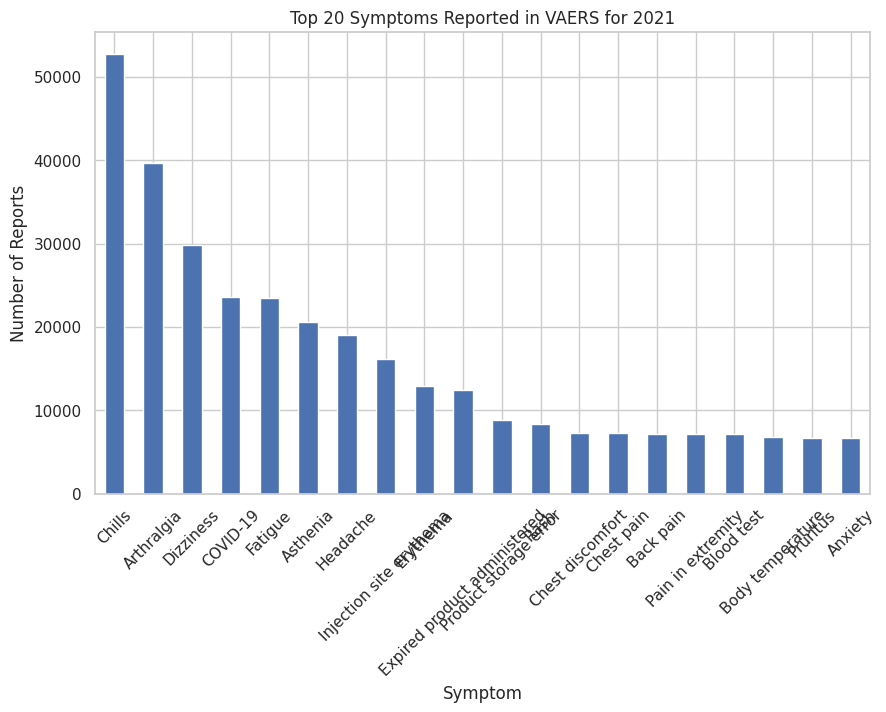

In [58]:
# prompt: plot symtoms1 top 20

import pandas as pd
import matplotlib.pyplot as plt

# Get the top 20 symptoms
top_20_symptoms = df_combine_2021['SYMPTOM1'].value_counts().head(20)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_20_symptoms.plot(kind='bar')

# Add title and labels
plt.title('Top 20 Symptoms Reported in VAERS for 2021')
plt.xlabel('Symptom')
plt.ylabel('Number of Reports')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [59]:
# prompt: how many people DIED by sex

died_by_sex = df_combine_2021.groupby('SEX')['DIED'].value_counts()
print(died_by_sex)


SEX  DIED
F    N       468487
     Y         4002
M    N       206991
     Y         5813
U    N        24951
     Y          421
Name: count, dtype: int64


In [60]:
# prompt: count SYMPTOM1

countSymtoms1=df_combine_2021['SYMPTOM1'].value_counts().head(20)
print(countSymtoms1)


SYMPTOM1
Chills                          52743
Arthralgia                      39643
Dizziness                       29830
COVID-19                        23633
Fatigue                         23451
Asthenia                        20590
Headache                        19063
Injection site erythema         16112
Erythema                        12927
Expired product administered    12490
Product storage error            8896
Rash                             8380
Chest discomfort                 7298
Chest pain                       7248
Back pain                        7135
Pain in extremity                7127
Blood test                       7115
Body temperature                 6754
Pruritus                         6733
Anxiety                          6727
Name: count, dtype: int64


In [61]:
# prompt: what us the most common symtom vaccine manu

most_common_symptom = df_combine_2021['SYMPTOM1'].mode()[0]
print(f"The most common symptom is: {most_common_symptom}")


The most common symptom is: Chills


In [62]:
# prompt: how many null values are the dataset df_vaers_vax_2021

df_combine_2021.isnull().sum()



VAERS_ID                0
AGE_YRS             67319
SEX                     0
DIED                    0
L_THREAT           699925
ER_VISIT           710564
HOSPITAL           664448
DISABLE            699646
VAX_TYPE                0
VAX_MANU                0
VAX_DOSE_SERIES      2682
SYMPTOM1                0
ALL_SYMPTOMS            0
dtype: int64

Number of VAERS by state

In [64]:
# prompt: drop the following columns SYMPTOM_TEXT, CAGE_MO, RPT_DATE,RECVDATE,, DISABLE,CUR_ILL, PRIOR_VAX, BIRTH_DEFECT, SYMPTOM_TEXT, CAGE_MO, RPT_DATE,RECVDATE,, DISABLE,CUR_ILL, PRIOR_VAX, BIRTH_DEFECT

df_combine_2021.drop(columns=['SYMPTOM_TEXT', 'CAGE_MO', 'RPT_DATE','RECVDATE','DISABLE','CUR_ILL', 'PRIOR_VAX', 'BIRTH_DEFECT','SYMPTOM2', 'SYMPTOM3','SYMPTOM4','SYMPTOM5','ALLERGIES'], axis=1, inplace=True, errors='ignore')


In [65]:
df_combine_2021['VAX_TYPE'].value_counts(normalize= True) * 100

VAX_TYPE
COVID19    100.0
Name: proportion, dtype: float64

In [66]:
df_combine_2021['VAX_MANU'].value_counts(normalize= True) * 100

VAX_MANU
MODERNA                 47.301190
PFIZER\BIONTECH         43.736078
JANSSEN                  8.747441
UNKNOWN MANUFACTURER     0.215291
Name: proportion, dtype: float64

In [67]:
df_combine_2021.columns

Index(['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'VAX_TYPE', 'VAX_MANU', 'VAX_DOSE_SERIES', 'SYMPTOM1',
       'ALL_SYMPTOMS'],
      dtype='object')

In [68]:
# prompt: give me numeric values vs categorical values

import pandas as pd



# Get numeric and categorical columns
numeric_cols = df_combine_2021.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_combine_2021.select_dtypes(include=['object']).columns

# Print the columns
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: Index(['VAERS_ID', 'AGE_YRS'], dtype='object')
Categorical columns: Index(['SEX', 'DIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'VAX_TYPE',
       'VAX_MANU', 'VAX_DOSE_SERIES', 'SYMPTOM1', 'ALL_SYMPTOMS'],
      dtype='object')


In [69]:
df_combine_2021['ER_VISIT'].value_counts()

ER_VISIT
Y    101
Name: count, dtype: int64

In [70]:
# Died - Replace 'nan' with 'N'
df_combine_2021['DIED'] = df_combine_2021['DIED'].replace({np.nan: 'N'})
# L_Threat - Replace 'nan' with 'N'
df_combine_2021['L_THREAT'] = df_combine_2021['L_THREAT'].replace({np.nan: 'N'})

# ER_ED_Visit - Replace 'nan' with 'N'
df_combine_2021['ER_VISIT'] = df_combine_2021['ER_VISIT'].replace({np.nan: 'N'})


# Hospital - Replace 'nan' with 'N'
df_combine_2021['HOSPITAL'] = df_combine_2021['HOSPITAL'].replace({np.nan: 'N'})

# Disable - Replace 'nan' with 'N'
#df_combine_2021['DISABLE'] = df_combine_2021['DISABLE'].replace({np.nan: 'N'})



In [1]:
# prompt: Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?, import  libraries ypu will need

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the data
df = df_combine_2021.copy()

# Preprocess the data
df.dropna(inplace=True)

# Create dummy variables for categorical features
df = pd.get_dummies(df, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_combine_2021.drop('DIED', axis=1), df_combine_2021['DIED'], test_size=0.25, random_state=0)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Get the coefficients of the model
coefficients = model.coef_

# Create a dataframe of the coefficients
coef_df = pd.DataFrame(coefficients, columns=X_train.columns)

# Sort the coefficients by absolute value
coef_df = coef_df.abs().sort_values(by=0, ascending=False)

# Print the top 10 coefficients
print(coef_df.head(10))



NameError: name 'df_combine_2021' is not defined

In [69]:
# prompt: Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?

import pandas as pd

# Select the relevant columns
df = df[['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']]

# Group the data by age, sex, vaccine brand, and death
grouped_data = df.groupby(['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']).size().unstack()

# Calculate the percentage of people who died for each group
grouped_data = grouped_data.apply(lambda x: x / x.sum() * 100, axis=1)

# Print the results
print(grouped_data)

# You can use this data to analyze the relationship between age, sex, vaccine brand, and the likelihood of death after vaccination. For example, you could use this data to identify groups of people who are at higher risk of experiencing severe side effects from the vaccine.


DIED                             N   Y
AGE_YRS SEX VAX_MANU                  
0.08    F   JANSSEN          100.0 NaN
            MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        M   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
...                            ...  ..
115.00  F   PFIZER\BIONTECH  100.0 NaN
119.00  F   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        U   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN

[1157 rows x 2 columns]


In [82]:
# prompt: Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?

import pandas as pd

# Read the data into a DataFrame

df=df_combine_2021.copy()

# Select the relevant columns
df = df[['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']]

# Group the data by age, sex, vaccine brand, and death
grouped_data = df.groupby(['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']).size().unstack()

# Calculate the percentage of people who died for each group
grouped_data = grouped_data.apply(lambda x: x / x.sum() * 100, axis=1)

# Print the results
print(grouped_data)


DIED                             N   Y
AGE_YRS SEX VAX_MANU                  
0.08    F   JANSSEN          100.0 NaN
            MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        M   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
...                            ...  ..
115.00  F   PFIZER\BIONTECH  100.0 NaN
119.00  F   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        U   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN

[1157 rows x 2 columns]


In [68]:
df_combine_2021.columns

Index(['AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'DISABLE',
       'BIRTH_DEFECT', 'VAX_TYPE', 'VAX_MANU', 'VAX_NAME', 'SYMPTOM1',
       'ALL_SYMPTOMS'],
      dtype='object')

In [71]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [4]:
cat = []
num = []

for i in df_combine_2021.columns:
    if df_combine_2021[i].dtype==object:
        cat.append(i)
    else:
        num.append(i)

print("The number of numerical features are:",len(num))
print()
print("The numerical features are:\n\n",num)
print("\n\n")
print("The number of categorical features are:", len(cat))
print()
print("The categorical features are:\n\n",cat)

NameError: name 'df_combine_2021' is not defined

In [3]:
df_v1=df_combine_2021.copy()
df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['HOSPITAL'] == 'N') & (df_v1['X_STAY'] == 'N') & (df_v1['OFC_VISIT'] == 'N') & (df_v1['DISABLE'] == 'N') & (df_v1['BIRTH_DEFECT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Birth_Defect'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['HOSPITAL'] == 'N') & (df_v1['X_STAY'] == 'N') & (df_v1['OFC_VISIT'] == 'N') & (df_v1['DISABLE'] == 'Y')), 'ADVERSE_EFFECT'] = 'Disabled'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['HOSPITAL'] == 'N') & (df_v1['X_STAY'] == 'N') & (df_v1['OFC_VISIT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Clinic_Visit'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['X_STAY'] == 'N')  & (df_v1['HOSPITAL'] == 'Y')), 'ADVERSE_EFFECT'] = 'Hospitalized'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['X_STAY'] == 'Y')), 'ADVERSE_EFFECT'] = 'Prolonged_Hospitalization'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'Y')), 'ADVERSE_EFFECT'] = 'ER_Visit'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Life_Threat'

df_v1.loc[((df_v1['DIED'] == 'Y')), 'ADVERSE_EFFECT'] = 'Died'

NameError: name 'df_combine_2021' is not defined

In [1]:
df_combine_2021.columns
df_combine_2021.head()

NameError: name 'df_combine_2021' is not defined